## Image网 Submission `128x128`

This contains a submission for the Image网 leaderboard in the `128x128` category.

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do image inpatining on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch

import numpy as np

from functools import partial
from fastai2.basics import *
from fastai2.vision.all import *

In [2]:
torch.cuda.set_device(1)

In [3]:
# Chosen parameters
lr=2e-2
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
bs=64 
sa=1

m = xresnet34
act_fn = Mish
pool = MaxPool

nc=20

In [4]:
source = untar_data(URLs.IMAGEWANG_160)
len(get_image_files(source/'unsup')), len(get_image_files(source/'train')), len(get_image_files(source/'val'))

(7750, 14669, 3929)

In [5]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [6]:
m_part = partial(m, c_out=nc, act_cls=torch.nn.ReLU, sa=sa, pool=pool)
model_meta[m_part] = model_meta[xresnet34]

In [8]:
save_name = 'imagewang_contrast_kornia_50ep_loweraug'

## Pretext Task: Contrastive Learning

In [9]:
#export
from pytorch_metric_learning import losses
class XentLoss(losses.NTXentLoss):
    def forward(self, output1, output2):
        stacked = torch.cat((output1, output2), dim=0)
        labels = torch.arange(output1.shape[0]).repeat(2)
        return super().forward(stacked, labels, None)
    
class ContrastCallback(Callback):
    run_before=Recorder
    def __init__(self, size=256, aug_targ=None, aug_pos=None, temperature=0.1):
        self.aug_targ = ifnone(aug_targ, get_aug_pipe(size))
        self.aug_pos = ifnone(aug_pos, get_aug_pipe(size))
        self.temperature = temperature
        
    def update_size(self, size):
        pipe_update_size(self.aug_targ, size)
        pipe_update_size(self.aug_pos, size)
        
    def begin_fit(self): 
        self.old_lf = self.learn.loss_func
        self.old_met = self.learn.metrics
        self.learn.metrics = []
        self.learn.loss_func = losses.NTXentLoss(self.temperature)
        
    def after_fit(self):
        self.learn.loss_fun = self.old_lf
        self.learn.metrics = self.old_met
        
    def begin_batch(self):
        xb, = self.learn.xb
        xb_targ = self.aug_targ(xb)
        xb_pos = self.aug_pos(xb)
        self.learn.xb = torch.cat((xb_targ, xb_pos), dim=0),
        self.learn.yb = torch.arange(xb_targ.shape[0]).repeat(2),
        

In [10]:
#export
def pipe_update_size(pipe, size):
    for tf in pipe.fs:
        if isinstance(tf, RandomResizedCropGPU):
            tf.size = size

In [11]:
def get_dbunch(size, bs, workers=8, dogs_only=False):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    folders = ['unsup', 'val'] if dogs_only else None
    files = get_image_files(source, folders=folders)
    
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=0.9)], 
            [parent_label, Categorize()]]
    
#     dsets = Datasets(files, tfms=tfms, splits=GrandparentSplitter(train_name='unsup', valid_name='val')(files))
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
#     batch_tfms = [IntToFloatTensor, *aug_transforms(p_lighting=1.0, max_lighting=0.9)]
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [12]:
size = 128
bs = 256

dbunch = get_dbunch(160, bs)
len(dbunch.train.dataset)

23714

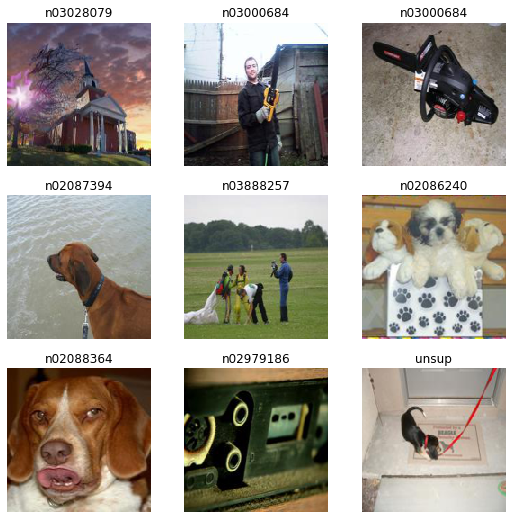

In [13]:
dbunch.show_batch()

In [14]:
# # xb = TensorImage(torch.randn(1, 3,128,128))
# afn_tfm, lght_tfm = aug_transforms(p_lighting=1.0, max_lighting=0.8, p_affine=1.0)
# # lght_tfm.split_idx = None
# xb.allclose(afn_tfm(xb)), xb.allclose(lght_tfm(xb, split_idx=0))

In [15]:
import kornia

In [16]:
#export
def get_aug_pipe(size, stats=None, s=.6):
    stats = ifnone(stats, imagenet_stats)
    rrc = kornia.augmentation.RandomResizedCrop((size,size), scale=(0.2, 1.0), ratio=(3/4, 4/3))
    rhf = kornia.augmentation.RandomHorizontalFlip()
    rcj = kornia.augmentation.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    
    tfms = [rrc, rhf, rcj, Normalize.from_stats(*stats)]
    pipe = Pipeline(tfms)
    pipe.split_idx = 0
    return pipe

In [17]:
aug = get_aug_pipe(size)
aug2 = get_aug_pipe(size)
cbs = ContrastCallback(size=size, aug_targ=aug, aug_pos=aug2, temperature=0.3)

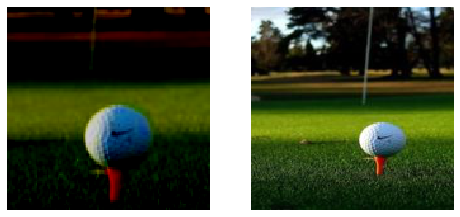

In [18]:
xb,yb = dbunch.one_batch()
nrm = Normalize.from_stats(*imagenet_stats)
xb_dec = nrm.decodes(aug(xb))
show_images([xb_dec[0], xb[0]])

In [19]:
ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128))
learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                    metrics=[], loss_func=CrossEntropyLossFlat(), cbs=cbs, pretrained=False,
                    config={'custom_head':ch}
                   ).to_fp16()

In [20]:
learn.unfreeze()
learn.fit_flat_cos(50, 2e-2, wd=1e-2, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,5.080403,4.898805,01:41
1,4.656218,4.622519,01:42
2,4.482541,4.520280,01:42
3,4.334817,4.382098,01:42
4,4.284407,4.505152,01:42
5,4.271651,4.369774,01:40
6,4.161961,4.192119,01:44
7,4.154332,4.463298,01:45
8,4.136353,4.112706,01:45
9,4.071827,4.293721,01:42


In [21]:
torch.save(learn.model[0].state_dict(), f'{save_name}.pth')

In [22]:
# learn.save(save_name)

## Downstream Task: Image Classification

In [23]:
def get_dbunch(size, bs, workers=8, dogs_only=False):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    if dogs_only:
        dog_categories = [f.name for f in (source/'val').ls()]
        dog_train = get_image_files(source/'train', folders=dog_categories)
        valid = get_image_files(source/'val')
        files = dog_train + valid
        splits = [range(len(dog_train)), range(len(dog_train), len(dog_train)+len(valid))]
    else:
        files = get_image_files(source)
        splits = GrandparentSplitter(valid_name='val')(files)
        
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [24]:
def do_train(size=128, bs=64, lr=1e-2, epochs=5, runs=5, dogs_only=False, save_name=None):
    dbunch = get_dbunch(size, bs, dogs_only=dogs_only)
    for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func, normalize=False,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy(),
#                 metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                pretrained=False,
                config={'custom_head':ch})

        if save_name is not None:
            state_dict = torch.load(f'{save_name}.pth')
            learn.model[0].load_state_dict(state_dict)

#             state_dict = torch.load('imagewang_inpainting_15_epochs_nopretrain.pth')
#             learn.model[0].load_state_dict(state_dict)
        learn.unfreeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2)

### 5 Epochs

In [25]:
epochs = 5
runs = 1

In [26]:
do_train(epochs=epochs, runs=runs, lr=2e-2, dogs_only=False, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.281448,2.346515,0.321456,0.831764,00:21
1,1.180368,2.384958,0.307203,0.762789,00:20
2,1.136037,2.434680,0.296004,0.746500,00:20
3,1.088318,2.805772,0.247391,0.663273,00:20
4,0.933876,1.818744,0.531942,0.904301,00:20


### 20 Epochs

In [27]:
epochs = 20
runs = 1

In [28]:
# LATEST
do_train(epochs=epochs, runs=runs, lr=2e-2, dogs_only=False, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.294588,2.434903,0.276661,0.742174,00:20
1,1.197500,2.451770,0.311784,0.800204,00:20
2,1.123675,2.530794,0.340290,0.793332,00:20
3,1.080519,2.109942,0.431917,0.853907,00:20
4,1.054472,2.151773,0.409010,0.861542,00:20
5,1.014942,1.936927,0.487401,0.878341,00:20
6,0.977651,1.947776,0.492492,0.871978,00:21
7,0.958228,2.065535,0.453805,0.834563,00:20
8,0.949421,1.990160,0.474675,0.881395,00:21
9,0.919169,2.102602,0.478239,0.801985,00:20


## 80 epochs

In [31]:
epochs = 80
runs = 1

In [ ]:
do_train(epochs=epochs, runs=runs, dogs_only=False, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.177778,2.264210,0.376686,0.834818,00:20
1,1.074262,2.153233,0.405701,0.823365,00:20
2,1.035078,1.925992,0.497837,0.881904,00:21
3,0.972095,2.125422,0.436498,0.833545,00:21


Accuracy: **62.18%**

### 200 epochs

In [37]:
epochs = 200
runs = 1

In [38]:
do_train(epochs=epochs, runs=runs, dogs_only=False, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.216668,2.168206,0.394757,0.822347,00:20
1,1.085281,2.000732,0.470094,0.850344,00:19
2,1.035700,1.953641,0.493001,0.890557,00:20
3,0.976597,1.982157,0.491474,0.843981,00:20
4,0.923220,1.968826,0.491728,0.870196,00:20
5,0.894018,1.849437,0.540341,0.882922,00:20
6,0.872596,1.822815,0.544413,0.880377,00:20
7,0.844638,1.893412,0.541868,0.877832,00:20
8,0.825782,1.847574,0.567320,0.894121,00:20
9,0.814316,1.892350,0.548231,0.868160,00:20


Accuracy: **62.03%**